In [1]:
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

In [3]:
from torchtext import data
from torchtext.data import Field, BucketIterator

import numpy as np


In [4]:
!pip install indic-nlp-library

In [5]:
# from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

# input_text="हाँ, हाँ, बिल्कुल. मैं उसे विफल रहा है, जीवन में।\n"
# remove_nuktas=False
# factory=IndicNormalizerFactory()
# normalizer=factory.get_normalizer("hi", remove_nuktas=True)
# output_text=normalizer.normalize(input_text)

# print(input_text)
# print()
# print(output_text)

# print('Before normalization')
# print(' '.join([ hex(ord(c)) for c in input_text ] ))
# print('Length: {}'.format(len(input_text)))
# print()    
# print('After normalization')
# print(' '.join([ hex(ord(c)) for c in output_text ] ))
# print('Length: {}'.format(len(output_text))) 

# from indicnlp.tokenize import indic_tokenize  

# indic_string='सुनो, कुछ आवाज़ आ रही है। फोन?'

# print('Input String: {}'.format(indic_string))
# print('Tokens: ')
# for t in hindi_tokenizer(indic_string): 
#     print(t)

In [6]:
import pandas as pd
df = pd.read_pickle("./en_hi.pkl")

In [7]:
from sklearn.model_selection import train_test_split
train_temp, test_data_sent = train_test_split(df, test_size = 0.2)
train_data_sent, validation_data_sent = train_test_split(train_temp, test_size=0.125)

In [8]:
train_data_sent.to_json('train_data.json', orient='records', lines=True)
validation_data_sent.to_json('validation_data.json', orient='records', lines=True)
test_data_sent.to_json('test_data.json', orient='records', lines=True)

In [9]:
!ls

encoder_decoder_without_attention.pt  sample_data     train_data.json
en_hi.pkl			      test_data.json  validation_data.json


In [10]:
!cat validation_data.json

{"english":"I've got one for you.\n","hindi":"\u0924\u0941\u092e\u094d\u0939\u093e\u0930\u0947 \u0932\u093f\u090f \u092d\u0940 \u090f\u0915 \u0939\u0948\u0964\n"}
{"english":"Every night, at dinner...\n","hindi":"\u0939\u0930 \u0930\u093e\u0924, \u0916\u093e\u0928\u0947 \u0915\u0947 \u0938\u092e\u092f...\n"}
{"english":"She'll kick us out!\n","hindi":"\u0939\u092e\u0947\u0902 \u0932\u093e\u0924 \u092e\u093e\u0930\u0915\u0930 \u092c\u093e\u0939\u0930 \u0915\u0930 \u0926\u0947\u0917\u0940!\n"}
{"english":"I come from nothing.\n","hindi":"\u092e\u0948\u0902 \u0915\u0941\u091b \u092d\u0940 \u0928\u0939\u0940\u0902 \u0938\u0947 \u0906\u0924\u0947 \u0939\u0948\u0902\u0964\n"}
{"english":"- Yeah, that, too.\n","hindi":"-\u092d\u0940 \u0939\u093e\u0901, \u0915\u093f,.\n"}
{"english":"She was so mean.\n","hindi":"\u0935\u0939 \u0907\u0924\u0928\u0940 \u091a\u093f\u0921\u093c\u091a\u093f\u0921\u093c\u0940 \u0925\u0940.\n"}
{"english":"This place is mine now.\n","hindi":"\u092f\u0939 \u091c\u0917

In [11]:
from indicnlp.tokenize import indic_tokenize

# from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
# factory=IndicNormalizerFactory()
# normalizer=factory.get_normalizer("hi", remove_nuktas=False)

def hindi_tokenizer(sentence):
    # sentence = re.sub(r"([.!?])", r" \1", sentence)
    # return [word for word in indic_tokenize.trivial_tokenize(normalizer.normalize(sentence.strip().split("-")[-1].strip()))]
    return [word for word in indic_tokenize.trivial_tokenize(sentence.strip().split("-")[-1].strip())]

In [12]:
import spacy
en_tokenizer = spacy.load('en')

def english_tokenizer(sentence):
    # sentence = re.sub(r"([.!?])", r" \1", sentence)
    # sentence = re.sub(r"[^a-zA-Z.!?]+", r" ", sentence)
    return [word.text for word in en_tokenizer.tokenizer(sentence.strip().split("-")[-1].strip())][::-1]

In [13]:
ENGLISH = Field(tokenize = english_tokenizer, init_token = '<sos>', eos_token = '<eos>', lower = True)
HINDI = Field(tokenize = hindi_tokenizer, init_token = '<sos>', eos_token = '<eos>')
fields = {'english': ('english', ENGLISH), 'hindi': ('hindi', HINDI)}

In [14]:
train_data, validation_data, test_data = data.TabularDataset.splits(path = '',
                                        train = 'train_data.json',
                                        validation = 'validation_data.json',
                                        test = 'test_data.json',
                                        format = 'json',
                                        fields = fields)

print(len(train_data), len(validation_data), len(test_data))

7000 1000 2000


In [15]:
# print(train_data_sent)
print(vars(train_data.examples[0]))

{'english': ['.', 'home', 'one', 'no', "'s", 'there'], 'hindi': ['कोई', 'घर', 'पर', 'नहीं', 'है', '.']}


In [16]:
ENGLISH.build_vocab(train_data, min_freq=2)
HINDI.build_vocab(train_data, min_freq=2)

print(f"English: {len(ENGLISH.vocab)}, Hindi: {len(HINDI.vocab)}")

English: 1828, Hindi: 2101


In [17]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(input_size, embedding_size) 
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, input):
        embeddings = self.dropout(self.word_embeddings(input)) # shape will be sentence_length x batch_size x embedding_size
        o, (h, c) = self.lstm(embeddings) # output shape will be sentence_length x batch_size x hidden size, hidden shape will be 1 x batch_size x hidden_size because we are returning only the final hidden layer

        return h, c

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, p):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.word_embeddings = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_size, hidden_size)
        self.linear = nn.Linear(embedding_size + hidden_size + hidden_size, output_size)
        self.output_size = output_size
        self.hidden_size = hidden_size

    def forward(self, input, h, c, z):        
        embeddings = self.dropout(self.word_embeddings(input)) # shape will be 1 x batch_size x embedding_size
        o, (h, c) = self.lstm(torch.cat((embeddings, z), dim = 2), (h, c)) # shape will be 1 x batch_size x hidden_size
        predictions = self.linear(torch.cat((embeddings, h, z), dim = 2).squeeze(0)) # both shapes will be batch_size x output_vocabulary_size

        return predictions, h, c

In [19]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.device = device
        self.encoder = encoder
        self.decoder = decoder
         
    def forward(self, input, actual):
        
        h, c = self.encoder(input)
        z = h
        input = actual[0, :]
        predictions = torch.zeros(actual.shape[0], actual.shape[1], self.decoder.output_size).to(self.device)

        for t in range(1, actual.shape[0]):
            o, h, c = self.decoder(input.unsqueeze(0), h, c, z)
            predictions[t] = o
            predicted = o.argmax(1) 
            input = predicted

        return predictions

In [20]:
# a = 4
# b = a
# a = 6
# a += 1
# print(a, b)

In [21]:
def train(model, train_data_iterator, optimizer, criterion):
    
    model.train()    
    total_loss = 0
    
    for batch in train_data_iterator:
        input = batch.english
        actual = batch.hindi
        optimizer.zero_grad()
        predictions = model(input, actual)
        vocab_size = predictions.shape[-1]
        predictions = predictions[1:].view(-1, vocab_size)
        actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
        loss = criterion(predictions, actual)
        loss.backward()   
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
    average_loss = total_loss / len(train_data_iterator)
    return average_loss

In [22]:
def evaluate(model, data_iterator, criterion):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_iterator:
            input = batch.english
            actual = batch.hindi
            predictions = model(input, actual)
            vocab_size = predictions.shape[-1]
            predictions = predictions[1:].view(-1, vocab_size)
            actual = actual[1:].view(-1) # flattening the sentence_length x batch_size dimensions because cross entropy loss needs 1d shape and also removing the sos token
            loss = criterion(predictions, actual)
            total_loss += loss.item()
    
    average_loss = total_loss / len(data_iterator)
    return average_loss

In [23]:
enc = Encoder(len(ENGLISH.vocab), 350, 512, 0.5)
dec = Decoder(len(HINDI.vocab), 350, 512, 0.5)

model = Model(enc, dec, device).to(device)
for name, param in model.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)
model

Model(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(1828, 350)
    (lstm): LSTM(350, 512)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (word_embeddings): Embedding(2101, 350)
    (lstm): LSTM(862, 512)
    (linear): Linear(in_features=1374, out_features=2101, bias=True)
  )
)

In [24]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = HINDI.vocab.stoi[HINDI.pad_token])

In [25]:
best_loss = 1e9

train_data_iterator, validation_data_iterator, test_data_iterator = BucketIterator.splits((train_data, validation_data, test_data), batch_size = 64, device = device, sort = False)

training_losses = []
validation_losses = []

for epoch in range(8):
    train_loss = train(model, train_data_iterator, optimizer, criterion)
    valid_loss = evaluate(model, validation_data_iterator, criterion)
    training_losses.append(np.exp(train_loss))
    validation_losses.append(np.exp(valid_loss))
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'encoder_decoder_without_attention.pt')
    
    print(f"Epoch: {epoch + 1}")
    print(f"Train Loss (exponent to analyse better): {np.exp(train_loss):.3f}")
    print(f"Val. Loss (exponent to analyse better): {np.exp(valid_loss):.3f}")

Epoch: 1
Train Loss (exponent to analyse better): 131.908
Val. Loss (exponent to analyse better): 70.374
Epoch: 2
Train Loss (exponent to analyse better): 74.735
Val. Loss (exponent to analyse better): 51.273
Epoch: 3
Train Loss (exponent to analyse better): 54.012
Val. Loss (exponent to analyse better): 43.970
Epoch: 4
Train Loss (exponent to analyse better): 41.173
Val. Loss (exponent to analyse better): 39.641
Epoch: 5
Train Loss (exponent to analyse better): 31.762
Val. Loss (exponent to analyse better): 36.087
Epoch: 6
Train Loss (exponent to analyse better): 24.868
Val. Loss (exponent to analyse better): 35.879
Epoch: 7
Train Loss (exponent to analyse better): 19.472
Val. Loss (exponent to analyse better): 35.699
Epoch: 8
Train Loss (exponent to analyse better): 15.289
Val. Loss (exponent to analyse better): 34.788


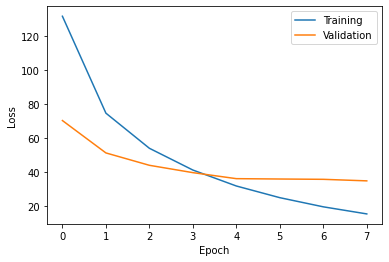

In [26]:
import matplotlib.pyplot as plt

plt.plot(training_losses, label = 'Training')
plt.plot(validation_losses, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# def get_tranlsation(text):
#   model.eval()
#   with torch.no_grad():
#     tokens = [token.text.lower() for token in en_tokenizer.tokenizer(text)][::-1]
#     tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
#     src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
#     src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
#     src_tensor = src_tensor.reshape(-1,1)
#     output = model(src_tensor, src_tensor)
#     output_dim = output.shape[-1]
#     output = output.view(-1, output_dim)
#     indices = torch.argmax(output,dim=1).tolist()
#     return [HINDI.vocab.itos[x] for x in indices]

# print(get_tranlsation("How do you do it?"))

In [28]:
model.load_state_dict(torch.load('encoder_decoder_without_attention.pt'))
test_loss = evaluate(model, test_data_iterator, criterion)
print(f"Test Loss (exponent to analyse better): {np.exp(test_loss):.3f}")

Test Loss (exponent to analyse better): 34.929


In [29]:
# vars(test_data.examples[2])

{'english': ['.', 'bro', ',', 'you', 'on', "'s", 'that'],
 'hindi': ['आप', 'पर', 'है', 'कि', ',', 'भाई', '.']}

In [53]:
def translate(text):
  model.eval()
  with torch.no_grad():
    tokens = english_tokenizer(text)
    tokens = [ENGLISH.init_token] + tokens + [ENGLISH.eos_token]
    src_indexes = [ENGLISH.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_tensor = src_tensor.reshape(-1,1)

    output = model(src_tensor, src_tensor)
    output_dim = output.shape[-1]
    output = output.view(-1, output_dim)
    indices = torch.argmax(output,dim=1).tolist()
    return [HINDI.vocab.itos[x] for x in indices]

print(translate("man speaking native language:"))

['सूचना', 'पुरुष', 'अपनी', '2', 'में', 'रहा', 'है']


In [55]:
import csv

translated_sentences = open('Paper1.csv','w')
csvwriter = csv.writer(translated_sentences)
csvwriter.writerow(['Input','Predicted','Actual'])  

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

translated_sentences.close()



In [60]:
with open('Paper1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} \t \t {row[1]} \t \t {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are Input, Predicted, Actual
	♪ TO, BABY, MESS AROUND 	 	 <unk> , <unk> , <unk> <unk> <unk> 	 	 ♪करनेके लिए,बेबी,चारोंओरगंदगी.
	It's not me, Astrid. 	 	 नहीं , , , , नहीं . 	 	 यह काम मेरे लिए उचित नहीं, ऐस्ट्रिड।.
	That's on you, bro. 	 	 आप , , , , , . 	 	 आप पर है कि, भाई..
	Are you kidding me? 	 	 तुम मुझे <unk> कर रहे ? 	 	 मज़ाक कर रहे हो?.
	Or we'll all die together. 	 	 हम हम हम <unk> जाएगा . 	 	 या हम सब एक साथ मरेंगे।.
	Fish, fish, fish, fish, fishy. 	 	 <unk> , <unk> , , , , <unk> <unk> <unk> 	 	 मछलियां, मछलियां, मछलियां, मछलियां..
	Why haven't I seen this? 	 	 क्या <unk> नहीं नहीं नहीं है ? 	 	 मैं ऐसा क्यों नहीं देखा है?.
	- No, we're not. 	 	 नहीं , हम हम हैं हैं . 	 	 - नहीं, हम नहीं कर रहे हैं..
	I have to find him! 	 	 <unk> <unk> <unk> है ! 	 	 मुझे उसे खोजना है!.
	Hardly Peter Ustinov, is he? 	 	 <unk> , वह , वह है है ? 	 	 पीटर उस्तीनोव तो नहीं समझता?.
	No, let me see. 	 	 <unk> , , मुझे <unk> . 	 	 नहीं, मुझे देखते हैं..
	Are you from Sardab? 	 	 <unk

In [59]:
# import csv

# translated_sentences = open('Paper2.csv','w')
# csvwriter = csv.writer(translated_sentences)
# csvwriter.writerow(['Input','Predicted','Actual'])  

import nltk

bleu_i = []
bleu_o = []

for i, (eng_sentence, hin_sentence) in enumerate(zip(test_data_sent["english"], test_data_sent["hindi"])):

  hindi_predicted = translate(eng_sentence)
  hindi_predicted = " ".join(list(filter(lambda x: x != '<eos>', hindi_predicted))[1:]).strip()
  # csvwriter.writerow([eng_sentence.strip(), hindi_predicted.strip(), hin_sentence.strip()])

  bleu_i.append(hin_sentence.strip())
  bleu_o.append(hindi_predicted.strip())

  # print(eng_sentence.strip())
  # print(hindi_predicted)
  # print()
  # print()

# translated_sentences.close()

BLEU_scores = []

for i in range(len(bleu_i)):
  BLEU_scores.append(nltk.translate.bleu_score.sentence_bleu(bleu_i[i], bleu_o[i], smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method7))
  
print("Average BLEU Score:", np.mean(BLEU_scores))



Average BLEU Score: 0.33565255962128826
